# Entrenamiento

Generamos el entrenamiento del modelo utilizando los datasets creados en el paso previo. 
El modelo es una red neuronal CNN basado en la arquitectura **U-Net**. Este considera las imágenes y las máscaras binarias como inputs y genera una imagen con la probabilidad de encontrar al objeto de interés.   


In [ ]:
!pip install unetseg

Las librerías que importamos nos permite acceder a las herramientas que vamos a utilizar a lo largo del proyecto como por ejemplo la función de train y predict  del modelo de Unet.

In [1]:
from unetseg.train import TrainConfig, train
from unetseg.evaluate import plot_data_generator
import os

/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/

En esta etapa debemos definir la configuración del modelo de ML


In [9]:
config = TrainConfig(width=160,  #  tamaño de la imagen procesada por la UNet (debe ser multiplos de 16 , por ej 160, 320,etc)
                     height=160,
                     n_channels=6,  #  número de canales de la imagen, rgb -> 3
                     n_classes=1, # número de clases a clasificar
                     apply_image_augmentation=True, #  si es True , amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes 
                     seed=42,
                     epochs=20, # Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento
                     batch_size=16, #cantidad de datos que se procesan por vez, puede ser limitado por la memoria de gpu disponible (debe ser multiplo de 16)
                     steps_per_epoch=150, #  típicamente debe ser igual al numero de imágenes / el batch_size, si es mayor incrementara el número de imágenes generadas con image augmentation
                     early_stopping_patience=5, # a medida que entrena se guarda los resultados del entrenamiento despues de cada epoch, si el error no varió luego de 3 iteraciones , se corta el proceso porque se entiende que el error ya disminuyó significativamente 
                     validation_split=0.2, # se divide la muestra en training y validation para calcular el error durante el proceso de entrenamiento
                     test_split=0.1,
                    
                     images_path=os.path.join('/home/ro/basurales/data/data_train','6D', '100_30'), #ruta a las imágenes
                     model_path=os.path.join('/home/ro/basurales/data/modelo/weights/', 'UNet_basurales_6D_100_30_spe150.h5'),#  ruta al archivo de entrenamiento
                     model_architecture='unet',
                     evaluate=True  ,
                     class_weights= [0.8]) 

In [ ]:
!ls ./../

Podemos visualizar alguna de las imágenes y máscaras.

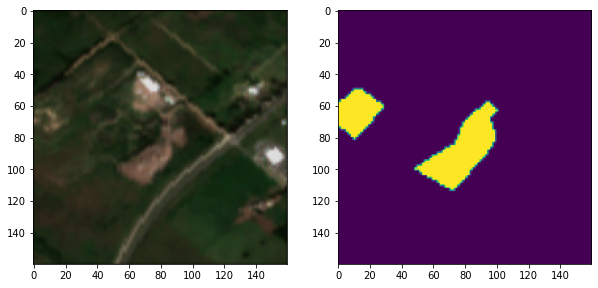

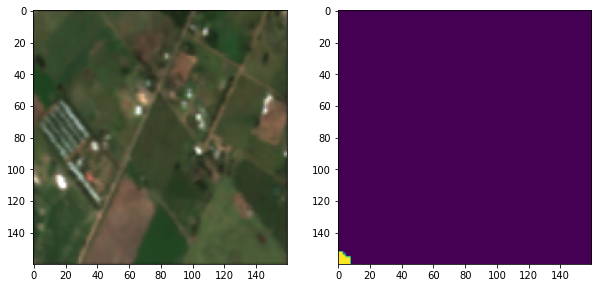

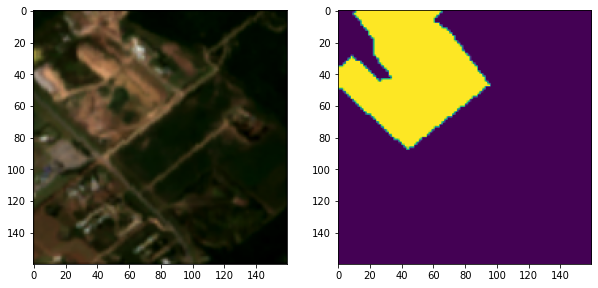

In [7]:
plot_data_generator(num_samples=3, fig_size=(10, 10), train_config=config,img_ch = 3)

Corremos el entrenamiento

In [10]:
res_config = train(config)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 160, 160, 6)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 160, 160, 32) 1760        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 160, 160, 32) 9248        conv2d_47[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 80, 80, 32)   0           conv2d_48[0][0]                  
____________________________________________________________________________________________

Epoch 1/20
150/150 [==============================] - 62s 411ms/step - loss: 0.1947 - mean_iou: 0.4793 - val_loss: 0.1143 - val_mean_iou: 0.4865

Epoch 00001: val_loss improved from inf to 0.11427, saving model to /home/ro/basurales/data/modelo/weights/UNet_basurales_6D_160_30_spe150.h5
Epoch 2/20
150/150 [==============================] - 67s 449ms/step - loss: 0.1027 - mean_iou: 0.4882 - val_loss: 0.1598 - val_mean_iou: 0.4964

Epoch 00002: val_loss did not improve from 0.11427
Epoch 3/20
150/150 [==============================] - 48s 320ms/step - loss: 0.0960 - mean_iou: 0.5028 - val_loss: 0.0779 - val_mean_iou: 0.5085

Epoch 00003: val_loss improved from 0.11427 to 0.07792, saving model to /home/ro/basurales/data/modelo/weights/UNet_basurales_6D_160_30_spe150.h5
Epoch 4/20
150/150 [==============================] - 61s 406ms/step - loss: 0.0933 - mean_iou: 0.5125 - val_loss: 0.1055 - val_mean_iou: 0.5180

Epoch 00004: val_loss did not improve from 0.07792
Epoch 5/20
150/150 [======

Graficamos las metricas generadas

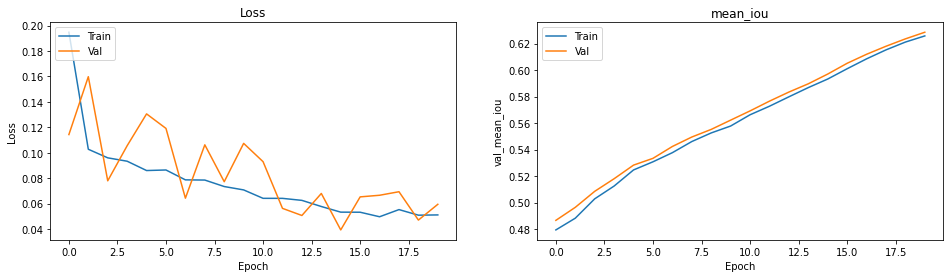

In [11]:
 import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(res_config.history['loss'])
plt.plot(res_config.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(res_config.history['mean_iou'])
plt.plot(res_config.history['val_mean_iou'])
plt.title('mean_iou')
plt.ylabel('val_mean_iou')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.show()